In [6]:
# Import libraries
import gym
from envs.binomial_tree import BinomialTree, decode_action    # custom BinomialTree dynamics
from envs import plotting
import numpy as np
import pandas as pd
import math
from collections import defaultdict
import itertools
import sys

In [7]:
actions = np.arange(0, 1.01, step=0.1)                  #vector of actions, discrete investment decisions in 10% steps
#actions = np.array([0, 0.68, 1])
print("Actions (Investment in risky asset):", actions)  
lower = 90                                              # upper limit of lowest wealth bin [0, lower)
upper = 110                                             # lower limit of highest wealth bin [upper, +Inf)
delta_bin = 20                                          # wealth-bin width
wealth_bins = [0] + np.arange(lower, upper+1, delta_bin).tolist() + [float('Inf')]  # +1 as upper limit is not included

Actions (Investment in risky asset): [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


**Epsilon-Greedy Policy**\
Source: https://www.geeksforgeeks.org/q-learning-in-python/#:~:text=Q%2DLearning%20is%20a%20basic,defined%20for%20states%20and%20actions.

In [9]:
def createEpsilonGreedyPolicy(Q, epsilon, num_actions): 
    """ 
    Creates an epsilon-greedy policy based 
    on a given Q-function and epsilon. 
       
    Returns a function that takes the state 
    as an input and returns the probabilities 
    for each action in the form of a numpy array  
    of length of the action space(set of possible actions). 
    """
    def policyFunction(state): 
   
        Action_probabilities = np.ones(num_actions, 
                dtype = float) * epsilon / num_actions 
                  
        best_action = np.argmax(Q[state]) 
        Action_probabilities[best_action] += (1.0 - epsilon) 
        return Action_probabilities 
   
    return policyFunction

**First Visit MonteCarlo** \
Source: https://github.com/dennybritz/reinforcement-learning/blob/master/MC/MC%20Control%20with%20Epsilon-Greedy%20Policies%20Solution.ipynb

In [19]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 10000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
        # The policy is improved implicitly by changing the Q dictionary
    
    return Q, policy

In [24]:
# Square root utility function
#up_prob, up_ret, down_ret, r, T, dt, V_0, actions, wealth_bins, utility
env = BinomialTree(up_prob=4/9, up_ret=1, down_ret=-1/2, r=0, T=2, dt=1, V_0=100, actions=actions, wealth_bins=wealth_bins, utility="sqrt")
Q, policy = mc_control_epsilon_greedy(env, num_episodes=2000000, epsilon=0.1)

Episode 2000000/2000000.

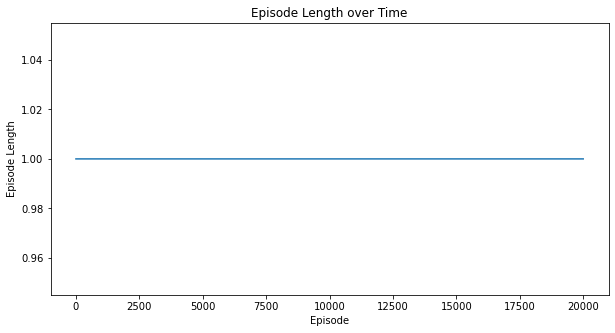

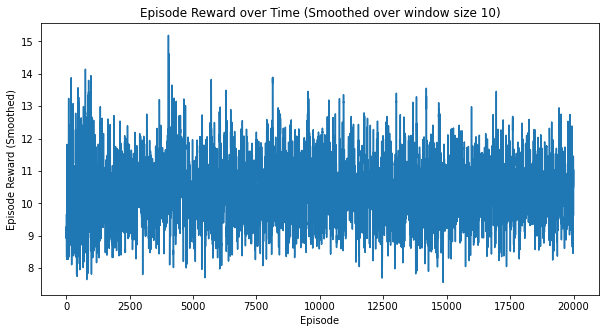

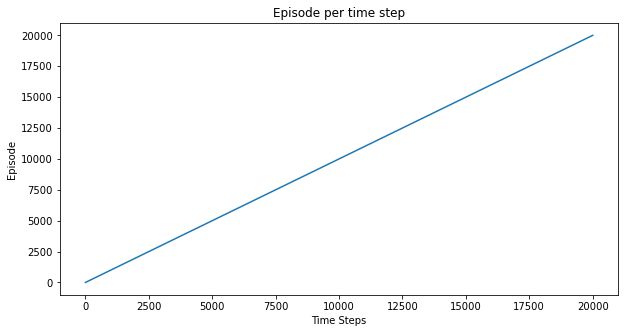

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [193]:
plotting.plot_episode_stats(stats) 

In [25]:
for key in Q.keys():
    print("Key:", key)
    print("State-Action Values:", Q[key], sep="\n")
    print("Best Action (Investment in risky asset):", decode_action(np.argmax(Q[key]), actions))

Key: (0, 1)
State-Action Values:
[10.25003071 10.3273275  10.39021276 10.45101158 10.45570373 10.51839577
 10.54157332 10.46610472 10.53298016 10.49136928 10.46363291]
Best Action (Investment in risky asset): 0.6000000000000001
Key: (1, 1)
State-Action Values:
[ 9.80481413  9.81521092  9.91147639  9.90955234  9.96449283 10.06138822
 10.0620722  10.05720633 10.05655554  9.89539551  9.93985109]
Best Action (Investment in risky asset): 0.6000000000000001
Key: (1, 0)
State-Action Values:
[8.34948509 8.41071953 8.46851294 8.52689691 8.54373938 8.56322337
 8.57804838 8.57131591 8.55377535 8.54792387 8.54168302]
Best Action (Investment in risky asset): 0.6000000000000001
Key: (1, 2)
State-Action Values:
[12.63544005 12.72278309 12.8011286  12.85931398 12.93090868 12.96450054
 12.96713672 12.96605255 12.96859687 12.96074175 12.88736646]
Best Action (Investment in risky asset): 0.8


In [26]:
# How often was each action take in each state
for key in A:
    print("State: {}, Actions: {}".format(key, A[key]))

NameError: name 'A' is not defined

[0.00909091 0.00909091 0.00909091 0.00909091 0.00909091 0.00909091
 0.90909091 0.00909091 0.00909091 0.00909091 0.00909091]
